# Preprocessing GTEx RNA-seq gene expression data

Here we preprocess the multi-tissue RNA-seq gene expression data from GTEx v6. Phenotype and RNA-seq gene expression data were downloaded from dbGaP.

**Subset samples and genes**

RNA-Seq samples included in the GTEx Analysis Freeze were used in this study. We kept only those tissues w/ samples > 30, which left us 27 tissues, 8525 samples for downstream analysis.

From the 56,318 genes represented in the GTEx data, we filtered out those consistently lowly-expressed genes (RPKM mean and SD < 1) (or called "low mean and variance genes"). This threshold was chosen because it appeared to separate background noise from signal (See figure below). A totoal of 211,46 genes were kept.

In [212]:
import pandas as pd
import seaborn as sns

In [214]:
%load_ext version_information
%version_information pandas, seaborn

Software versions
Python 2.7.12 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 4.1.2
OS Linux 2.6.32 431.3.1.el6.x86_64 x86_64 with centos 6.8 Final
pandas 0.18.0
seaborn 0.7.0
Wed Nov 23 14:13:41 2016 EST

# Setup

In [82]:
# Input
EXPRESSION = "/dev/shm/GTEx/GTEx_Data_20150112_RNAseq_RNASeQCv1.1.8_gene_rpkm.gct"
PHENOTYPE = "../../../src/GTEx/dbGaP/phs000424.v6.pht002743.v6.p1.c1.GTEx_Sample_Attributes.GRU.txt"

# Output
SAMPLES_TO_USE = "../data/GTEx.samples_to_use.tsv"
GENES_TO_USE = "../data/GTEx.genes_to_use.tsv"

# Read phenotype data

## Subset samples

In [69]:
pData = pd.read_table(PHENOTYPE, index_col=1, skiprows=10)  # use skiprows, do not use comment="#", "#" was used in the data
pData_1 = pData[pData.SMGEBTCHT == 'TrueSeq.v1']  # subset of RNA-seq samples
pData_2 = pData_1[pData_1.SMAFRZE == 'USE ME']  # subset of samples included in the GTEx Analysis Freeze
print pData_2.shape

(8555, 75)


## Tissue-sample counts

We pick up only those tissues w/ samples > 30.

In [81]:
tissue_col = pData_2.SMTS.dropna().astype('category')
tiss_samp_counts = tissue_col.value_counts(ascending=False)[tissue_col.value_counts() > 30]
tissues = tiss_samp_counts.index
samples = [i for i,x in tissue_col.iteritems() if x in tissues]
print "%d tissues, %d samples" % (len(tissues), len(samples))
print tiss_samp_counts

27 tissues, 8525 samples
Brain              1259
Skin                890
Blood Vessel        689
Esophagus           686
Adipose Tissue      577
Blood               511
Muscle              430
Heart               412
Colon               345
Thyroid             323
Lung                320
Nerve               304
Breast              214
Stomach             192
Testis              172
Pancreas            171
Adrenal Gland       145
Liver               119
Prostate            106
Spleen              104
Pituitary           103
Ovary                97
Vagina               96
Small Intestine      88
Uterus               83
Salivary Gland       57
Kidney               32
dtype: int64


## Output the sample list

In [169]:
pData.SMTS.loc[samples].to_csv(SAMPLES_TO_USE, sep="\t", header=True)

# Read expression data

In [85]:
exprs = pd.read_table(EXPRESSION, header=2, index_col=0)
exprs.shape

(56318, 9591)

## Subset expression data

Subset to those samples we selected

In [103]:
exprs_1 = exprs[samples]
exprs_1.shape

(56318, 8525)

Filter out consistently lowly-expressed genes (mean & SD both < 1)

In [123]:
#nonzeros = (exprs_1 != 0).sum(axis=1)  # how many non-zero values in each row

exprs_means = exprs_1.mean(axis=1)  # mean expression value for each row
exprs_stds = exprs_1.std(axis=1)  # mean expression value for each row

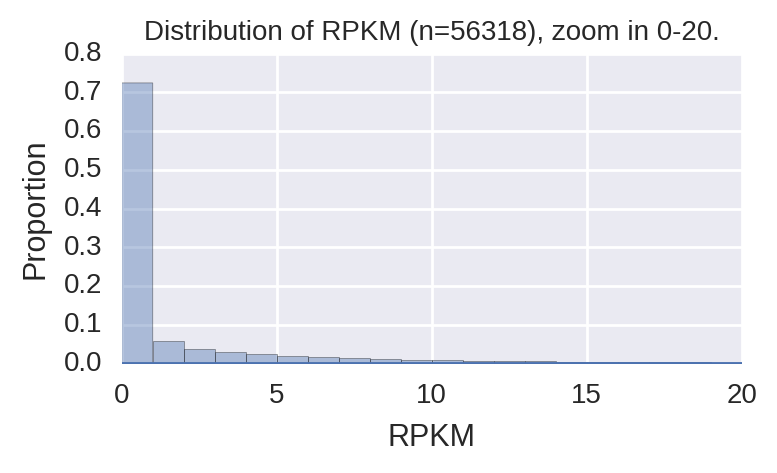

In [200]:
figure(figsize=(4,2))
ax = sns.distplot(exprs_means, bins=range(20))
#ax = sns.distplot(exprs_means, bins=linspace(0, 20, 201))  # higher resolution
ax.set_xlim(0, 20)
ax.set_xlabel('RPKM')
ax.set_ylabel('Proportion')
ax.set_title('Distribution of RPKM (n=%d), zoom in 0-20.' % len(exprs_means), fontdict={'fontsize': 'small'})

In [201]:
print "Total genes in GTEx:", exprs.shape[0]
print "#genes to remove:", sum((exprs_means < 1) | (exprs_stds < 1))
print "#genes to keep:", sum((exprs_means >= 1) | (exprs_stds >= 1))

Total genes in GTEx: 56318
#genes to remove: 39062
#genes to keep: 21146


In [203]:
exprs_2 = exprs_1[(exprs_means >= 1) | (exprs_stds >= 1)]
exprs_2.shape

(21146, 8525)

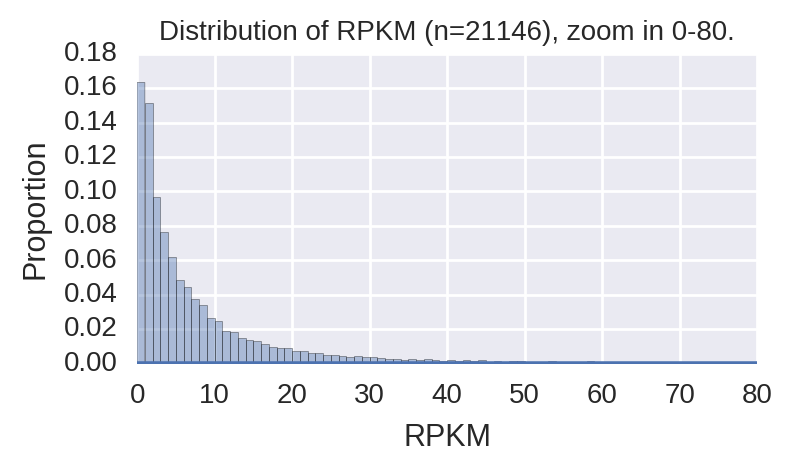

In [210]:
figure(figsize=(4,2))
ax = sns.distplot(exprs_2.mean(axis=1), bins=range(80))
ax.set_xlim(0, 80)
ax.set_xlabel('RPKM')
ax.set_ylabel('Proportion')
ax.set_title('Distribution of RPKM (n=%d), zoom in 0-80.' % exprs_2.shape[0], fontdict={'fontsize': 'small'})

## Output the gene list

In [211]:
genes = exprs_2.index
exprs.Description.loc[genes].to_csv(GENES_TO_USE, sep="\t", header=True)